# Machine Learning: Ridge Regression
#### Dataset Information:
Number of Attributes: 11  
Number of Instances: 4492  (1 minute interval)

### Table of Contents<a name='table of contents'></a>

1. [Data Ingestion](#data ingestion)
2. [Features & Target Arrays](#features and target arrays)
3. [Ridge Regression](#ridge)  
    a. [Residuals Plot](#residuals plot)  
    b. [Prediction Error Plot](#prediction error plot)  
4. [RidgeCV](#ridgecv)  
    a. [Residuals Plot](#updated residuals plot)  
    b. [Prediction Error Plot](#updated prediction error plot)  
5. [Save Model](#pickle)

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import yellowbrick as yb
sns.set_palette('RdBu', 10)

## Data Ingestion<a name='data ingestion'></a>

In [2]:
URL = 'https://raw.githubusercontent.com/georgetown-analytics/classroom-occupancy/master/models/sensor_data_ml.csv'

def fetch_data(fname='sensor_data_ml.csv'):
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Defining fetching data from the URL
DATA = fetch_data()

In [3]:
# Import sensor data
df = pd.read_csv('sensor_data_ml.csv', index_col='datetime', parse_dates=True)

# Rename columns
df.columns = ['temp', 'humidity', 'co2', 'light', 'light_st',
              'noise', 'bluetooth', 'images', 'door', 'occupancy_count', 'occupancy_level']

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4492 entries, 2017-03-25 09:05:00 to 2017-06-10 16:47:00
Data columns (total 11 columns):
temp               4492 non-null float64
humidity           4492 non-null float64
co2                4492 non-null float64
light              4492 non-null float64
light_st           4492 non-null float64
noise              4492 non-null float64
bluetooth          4492 non-null float64
images             4492 non-null float64
door               4492 non-null float64
occupancy_count    4492 non-null float64
occupancy_level    4492 non-null object
dtypes: float64(10), object(1)
memory usage: 421.1+ KB


,temp,humidity,co2,light,light_st,noise,bluetooth,images,door,occupancy_count,occupancy_level
datetime,,,,,,,,,,,
2017-03-25 09:05:00,22.600000,36.900000,781.000000,430.000000,1.0,511.000000,1.000000,15.242697,0.000000,0.000000,empty
2017-03-25 09:06:00,23.800000,38.954167,765.465279,428.533744,1.0,503.515931,11.399457,15.242697,0.000000,0.000000,empty
2017-03-25 09:07:00,23.850000,38.900000,768.458333,423.576500,1.0,510.548913,19.916667,15.242697,0.083333,4.416667,low
2017-03-25 09:08:00,23.900000,38.766667,777.791667,423.053571,1.0,506.504630,29.750000,15.242697,0.000000,23.416667,mid-level
2017-03-25 09:09:00,23.908333,38.733333,770.864583,438.607904,1.0,500.092672,35.860577,15.242697,0.000000,30.000000,high


## Features & Target Arrays<a name='features and target arrays'></a>

In [5]:
# Drop 'occupancy_level' column
df.drop('occupancy_level', axis=1, inplace=True)

In [6]:
from sklearn.model_selection import TimeSeriesSplit

# Create feature and target arrays
X = df.drop('occupancy_count', axis=1).values
y = df['occupancy_count']

tscv = TimeSeriesSplit(n_splits=12)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Ridge<a name='ridge'></a>

In [10]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Create a ridge regression object: ridge
ridge = Ridge().fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = ridge.predict(X_test)

# Print mean squared error and coefficient of determination
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(y_test, y_pred))))
print('Mean Squared Error: {:.3f}'.format(mse(y_test, y_pred)))
print('Coefficient of Determination: {:.3f}'.format(r2_score(y_test, y_pred)))

Root Mean Squared Error: 9.718
Mean Squared Error: 94.431
Coefficient of Determination: 0.230


In [12]:
print('ridge.coef_: {}'.format(ridge.coef_))
print('ridge.intercept_: {:.3f}'.format(ridge.intercept_))

ridge.coef_: [ -2.92272901e+00   5.62272714e-01   5.75341006e-02  -7.84558765e-03
  -1.93717018e+01   6.02406008e-02  -1.67847470e-02  -7.53378665e-02
  -6.34686056e-01]
ridge.intercept_: 6.678


#### Residuals Plot <a name='residuals plot'></a>

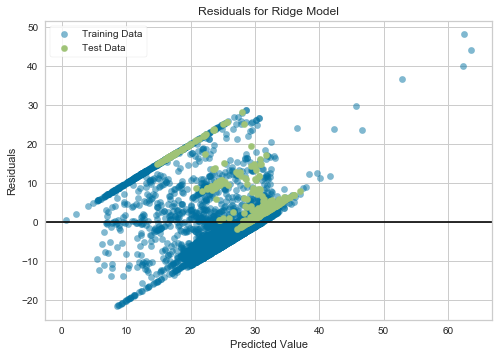

In [13]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ridge)

fig = plt.figure()
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof() 
#plt.savefig('ml_graphs/ridge_residuals_plot.png')

#### Prediction Error Plot <a name='prediction error plot'></a>

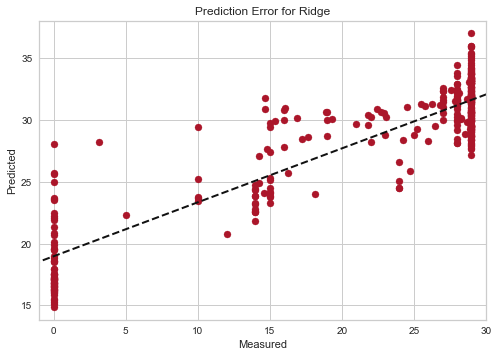

In [14]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(ridge)

fig = plt.figure()
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
#plt.savefig('ml_graphs/ridge_prediction_error.png')

## Hyperparameter Tuning<a name='ridgecv'></a>

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, RobustScaler

pipe = make_pipeline(RobustScaler(),
                     PolynomialFeatures(),
                     Ridge())

param_grid = {'polynomialfeatures__degree': [0, 1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid, cv=tscv, n_jobs =-1)

ridgecv = grid.fit(X_train, y_train)

print('Best estimator:\n{}'.format(ridgecv.best_estimator_))

Best estimator:
Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('polynomialfeatures', PolynomialFeatures(degree=0, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])


In [16]:
print('Best score: {:.4f}'.format(ridgecv.best_score_))
print('Best parameters: {}'.format(ridgecv.best_params_))

Best score: -0.0571
Best parameters: {'ridge__alpha': 0.001, 'polynomialfeatures__degree': 0}


In [19]:
y_pred = ridgecv.predict(X_test)

print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(y_test, y_pred))))
print('Mean Squared Error: {:.3f}'.format(mse(y_test, y_pred)))
print('Coefficent of Determination: {:.3f}'.format(r2_score(y_test, y_pred)))

Root Mean Squared Error: 11.478
Mean Squared Error: 131.746
Coefficent of Determination: -0.074


## Save Model<a name='pickle'></a>

In [20]:
import pickle

ridge_model = 'ridge_model.sav'

# Save fitted model to disk
pickle.dump(ridgecv, open(ridge_model, 'wb'))

### [Return to Table of Contents](#table of contents)

In [21]:
loaded_model = pickle.load(open(ridge_model, 'rb'))

result = loaded_model.score(X_test, y_test)
print(result)

-0.074039852225
